# 1. Finding top 3 variables that have most impact on freelancer earnings

### Import Library

In [1]:
import gspread
from google.oauth2.service_account import Credentials
import pandas as pd
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data from Spreadsheet

In [2]:
load_dotenv()

API_BASE = os.getenv("API_BASE")
SPREADSHEET_KEY = os.getenv("SPREADSHEET_KEY")
WORKSHEET_NAME = os.getenv("WORKSHEET_NAME")
CREDENTIALS_FILE = os.getenv("GOOGLE_CREDENTIALS_FILE")

SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file(CREDENTIALS_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

In [3]:
sheet = client.open_by_key(SPREADSHEET_KEY).worksheet(WORKSHEET_NAME)
df = pd.DataFrame(sheet.get_all_records())
df.head()

,TEMP08-ciphertext,Do Not Delete,TEMP09-shortName,TEMP12-companyFullName,TEMP15-upworkUrl,Status,Date,First name,Last name,Freelancer,...,PD20-memberSince,TEMP11-combinedRecentEarnings,TEMP13-combinedTotalRevenue,TEMP14-description,TEMP15-avgFeedbackscore,PD18-companyLogo,PC09-Owner,PD08-Research-Campaign,TEMP16-Created,Last Modified Date & TIme
0,~01f8fa804776fa47f4,01f8fa804776fa47f4,Omar E.,Vertex Master,https://www.upwork.com/profile-portraits/c1m0w...,,29-04-2023,,,FALSE,...,February 2017,$1K,$1K,iOS Developer\nI am an iOS app developer havin...,4.980000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
1,~01da9f9970b04adf80,01da9f9970b04adf80,Khushwant S.,SSK Business Services Ltd.,https://www.upwork.com/profile-portraits/c1frP...,,29-04-2023,,,FALSE,...,December 2016,$99K,$283K,"Hello,\nI have 5+ years of experience in Hybri...",4.680000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
2,~0101f491b0cdd8590b,0101f491b0cdd8590b,Kutay K.,Activate Inspiration,https://www.upwork.com/profile-portraits/c1yAi...,,29-04-2023,,,FALSE,...,October 2021,$24K,$46K,✅ 6+ Years Experience ✅ 10+ Mobile Apps\nI hav...,4.910000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
3,~0120de507c728f8d9e,0120de507c728f8d9e,Muhammad A.,IamSolution,https://www.upwork.com/profile-portraits/c1Kt5...,READY,22-11-2025,,,False,...,September 2019,$8K,$9K,Experienced DBA and have expertise in\n1. MySQ...,4.920739,,,,22/11/2025,
4,~01c96ae21099f1079f,01c96ae21099f1079f,Kinjal P.,Vrinsoft Technology Pvt. Ltd,https://www.upwork.com/profile-portraits/c1XyD...,READY,22-11-2025,,,False,...,September 2021,$11K,$32K,Greetings!\nNow that we are moving towards the...,4.520598,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,


### Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0    TEMP08-ciphertext             243 non-null    object 
 1   Do Not Delete                  243 non-null    object 
 2   TEMP09-shortName               243 non-null    object 
 3   TEMP12-companyFullName         243 non-null    object 
 4   TEMP15-upworkUrl               243 non-null    object 
 5   Status                         243 non-null    object 
 6   Date                           243 non-null    object 
 7   First name                     243 non-null    object 
 8   Last name                      243 non-null    object 
 9   Freelancer                     243 non-null    object 
 10  Email                          243 non-null    object 
 11  Phone                          243 non-null    object 
 12  Company Phone                  243 non-null    obj

In [5]:
df.isna().sum()

 TEMP08-ciphertext               0
Do Not Delete                    0
TEMP09-shortName                 0
TEMP12-companyFullName           0
TEMP15-upworkUrl                 0
Status                           0
Date                             0
First name                       0
Last name                        0
Freelancer                       0
Email                            0
Phone                            0
Company Phone                    0
Job Title                        0
PD11-Department                  0
PD12-Seniority-Level             0
PD13-Persona                     0
PC01-Company-Short               0
PC02-CompanyS                    0
PC06-2nd-person-full             0
PC07-2nd-person-first            0
PC08-Website                     0
PD06-Company-Country             0
PC10-Company-Linkedin            0
PD01-Prospect-Linkedin           0
Source URL                       0
PD07-Industry                    0
PD09-Company-Size                0
UN01-Solutions      

In [6]:
df.duplicated().sum()

np.int64(0)

### Data Cleaning

In [7]:
def parse_currency(value):
    """Convert object into numeric value"""
    if pd.isna(value) or value == '' or value == 'None':
        return 0
    
    value = str(value).strip()
    if value == '':
        return 0
    
    value = value.replace('$', '')
    value = value.upper().replace('K', '')
    try:
        return float(value) * 1000
    except:
        return 0


In [8]:
df_clean = df.copy()

currency_cols = currency_cols = [
        'PD02-combinedTotalRevenue',
        'PD14-combinedRecentEarnings', 
        'TEMP11-combinedRecentEarnings',
        'TEMP13-combinedTotalRevenue'
    ]

for col in currency_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(parse_currency)

In [9]:
def convert_deadline(val):
    if pd.isna(val) or val == '' or str(val).lower() == 'none':
        return 0
    try:
        return float(val)
    except:
        return np.nan

In [10]:
df_clean['TEMP02-avgDeadlinesScore'] = df_clean['TEMP02-avgDeadlinesScore'].apply(convert_deadline)

In [11]:
df_clean.head(100)

,TEMP08-ciphertext,Do Not Delete,TEMP09-shortName,TEMP12-companyFullName,TEMP15-upworkUrl,Status,Date,First name,Last name,Freelancer,...,PD20-memberSince,TEMP11-combinedRecentEarnings,TEMP13-combinedTotalRevenue,TEMP14-description,TEMP15-avgFeedbackscore,PD18-companyLogo,PC09-Owner,PD08-Research-Campaign,TEMP16-Created,Last Modified Date & TIme
0,~01f8fa804776fa47f4,01f8fa804776fa47f4,Omar E.,Vertex Master,https://www.upwork.com/profile-portraits/c1m0w...,,29-04-2023,,,FALSE,...,February 2017,1000.0,1000.0,iOS Developer\nI am an iOS app developer havin...,4.980000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
1,~01da9f9970b04adf80,01da9f9970b04adf80,Khushwant S.,SSK Business Services Ltd.,https://www.upwork.com/profile-portraits/c1frP...,,29-04-2023,,,FALSE,...,December 2016,99000.0,283000.0,"Hello,\nI have 5+ years of experience in Hybri...",4.680000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
2,~0101f491b0cdd8590b,0101f491b0cdd8590b,Kutay K.,Activate Inspiration,https://www.upwork.com/profile-portraits/c1yAi...,,29-04-2023,,,FALSE,...,October 2021,24000.0,46000.0,✅ 6+ Years Experience ✅ 10+ Mobile Apps\nI hav...,4.910000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,01/10/2023,
3,~0120de507c728f8d9e,0120de507c728f8d9e,Muhammad A.,IamSolution,https://www.upwork.com/profile-portraits/c1Kt5...,READY,22-11-2025,,,False,...,September 2019,8000.0,9000.0,Experienced DBA and have expertise in\n1. MySQ...,4.920739,,,,22/11/2025,
4,~01c96ae21099f1079f,01c96ae21099f1079f,Kinjal P.,Vrinsoft Technology Pvt. Ltd,https://www.upwork.com/profile-portraits/c1XyD...,READY,22-11-2025,,,False,...,September 2021,11000.0,32000.0,Greetings!\nNow that we are moving towards the...,4.520598,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,~016f4b111aac826ed7,016f4b111aac826ed7,Anton V.,T-Spark Engineering,https://www.upwork.com/profile-portraits/c14Np...,RAW,22-11-2025,,,False,...,June 2016,34000.0,210000.0,Expert (more then 50 successfully realized pro...,4.787463,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,
96,~013c89503dcdfc7cf7,013c89503dcdfc7cf7,Ayush A.,Extern Labs Pvt. Ltd.,https://www.upwork.com/profile-portraits/c1c32...,RAW,22-11-2025,,,False,...,July 2019,287000.0,138000.0,Embedded systems designer dedicated to take yo...,4.811965,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,
97,~010b40bef7e293c661,010b40bef7e293c661,Amitesh M.,Trident Analytical Solutions Pvt. Ltd.,https://www.upwork.com/profile-portraits/c1V9O...,RAW,22-11-2025,,,False,...,January 2011,0.0,236000.0,I am a full stack Blockchain developer with ex...,4.716452,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,
98,~01e5242fb00774a9d2,01e5242fb00774a9d2,Sandeep C.,EIY SYS PRIVATE LIMITED,https://www.upwork.com/profile-portraits/c1YZ5...,RAW,22-11-2025,,,False,...,May 2021,16000.0,137000.0,"\nHello everyone,\n\nI am a Blockchain develop...",5.000000,https://upwork-usw2-prod-assets-static.s3.us-w...,,,22/11/2025,


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0    TEMP08-ciphertext             243 non-null    object 
 1   Do Not Delete                  243 non-null    object 
 2   TEMP09-shortName               243 non-null    object 
 3   TEMP12-companyFullName         243 non-null    object 
 4   TEMP15-upworkUrl               243 non-null    object 
 5   Status                         243 non-null    object 
 6   Date                           243 non-null    object 
 7   First name                     243 non-null    object 
 8   Last name                      243 non-null    object 
 9   Freelancer                     243 non-null    object 
 10  Email                          243 non-null    object 
 11  Phone                          243 non-null    object 
 12  Company Phone                  243 non-null    obj

In [13]:
df_clean['TEMP15-avgFeedbackscore'] = pd.to_numeric(df_clean['TEMP15-avgFeedbackscore'])

### Prepare Data

- Mapping Target, and Feature

In [50]:
target_col = 'PD02-combinedTotalRevenue'

feature_mapping = {
        'PD03-totalHourlyJobs': 'Total Hourly Jobs',
        'TEMP01-workingYears': 'Working Years',
        'TEMP02-avgDeadlinesScore': 'Avg Deadlines Score',
        'TEMP15-avgFeedbackscore': 'Avg Feedback Score',
    }

categorical_features = {
        'TEMP04-agencyTopRatedStatus': 'Top Rated Status',
        'PD06-Company-Country': 'Country',
        'TEMP03-serviceProfileNames': 'Service Type',
    }

- Label Encoding

In [51]:
le = LabelEncoder()
for col, name in categorical_features.items():
    if col in df_clean.columns:
        df_clean[col + '_encoded'] = le.fit_transform(
            df_clean[col].astype(str)
        )
        feature_mapping[col + '_encoded'] = name

In [52]:
available_features = [f for f in feature_mapping.keys() if f in df_clean.columns]

In [ ]:
X = df_clean[available_features].copy()
y = df_clean[target_col].copy()

X = X.fillna(0)
y = y.fillna(0)

mask = y > 0
X = X[mask]
y = y[mask]

In [55]:
print(f"\nAnalyzing {len(X)} freelancers with earnings data")
print(f"Features analyzed: {len(available_features)}")


Analyzing 232 freelancers with earnings data
Features analyzed: 7


### Analyze using Correlation Matrix

In [56]:
correlations = {}
for col in available_features:
    corr = X[col].corr(y)
    correlations[feature_mapping[col]] = corr

corr_sorted = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nCorrelation with Earnings (sorted by absolute value):")
for name, corr in corr_sorted:
    print(f"  {name:25s}: {corr:+.4f}")


Correlation with Earnings (sorted by absolute value):
  Working Years            : -0.0778
  Country                  : +0.0691
  Avg Feedback Score       : -0.0573
  Service Type             : -0.0553
  Total Hourly Jobs        : +0.0252
  Avg Deadlines Score      : -0.0232
  Top Rated Status         : +0.0075


### Analyze using Random Forest Feature Importances

In [57]:
rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
rf_model.fit(X, y)

importances = dict(zip(
    [feature_mapping[f] for f in available_features],
    rf_model.feature_importances_
))

imp_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importance (Random Forest):")
for name, imp in imp_sorted:
    print(f"  {name:25s}: {imp:.4f} ({imp*100:.1f}%)")


Feature Importance (Random Forest):
  Total Hourly Jobs        : 0.2489 (24.9%)
  Avg Feedback Score       : 0.2037 (20.4%)
  Avg Deadlines Score      : 0.1650 (16.5%)
  Working Years            : 0.1646 (16.5%)
  Country                  : 0.1001 (10.0%)
  Service Type             : 0.0624 (6.2%)
  Top Rated Status         : 0.0552 (5.5%)


### TOP 3 VARIABLES IMPACTING FREEELANCER EARNINGS

- Showing top 3 variables that most impact to the freelancer earnings

In [58]:
print("TOP 3 VARIABLES IMPACTING FREELANCER EARNINGS")

top_3 = imp_sorted[:3]
for i, (name, imp) in enumerate(top_3, 1):
    corr_val = correlations.get(name, 0)
    print(f"\n{i}. {name}")
    print(f"   - Feature Importance: {imp:.4f} ({imp*100:.1f}%)")
    print(f"   - Correlation: {corr_val:+.4f}")

TOP 3 VARIABLES IMPACTING FREELANCER EARNINGS

1. Total Hourly Jobs
   - Feature Importance: 0.2489 (24.9%)
   - Correlation: +0.0252

2. Avg Feedback Score
   - Feature Importance: 0.2037 (20.4%)
   - Correlation: -0.0573

3. Avg Deadlines Score
   - Feature Importance: 0.1650 (16.5%)
   - Correlation: -0.0232


- Showing plot

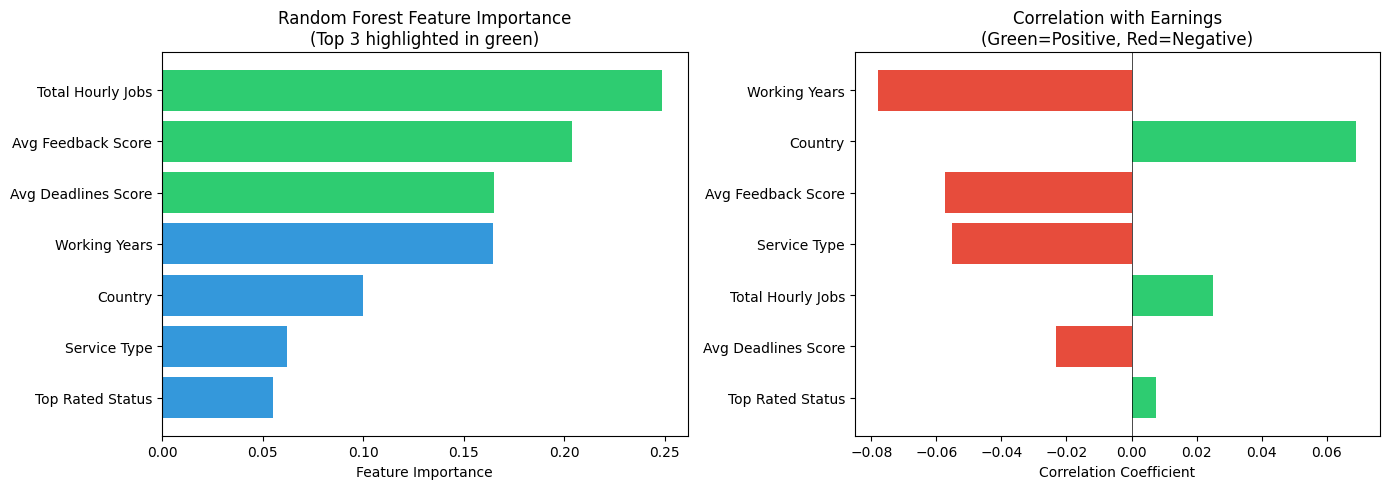

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = [x[0] for x in imp_sorted]
values = [x[1] for x in imp_sorted]
colors = ['#2ecc71' if i < 3 else '#3498db' for i in range(len(names))]

axes[0].barh(names[::-1], values[::-1], color=colors[::-1])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Random Forest Feature Importance\n(Top 3 highlighted in green)')

corr_names = [x[0] for x in corr_sorted]
corr_values = [x[1] for x in corr_sorted]
colors2 = ['#e74c3c' if v < 0 else '#2ecc71' for v in corr_values]

axes[1].barh(corr_names[::-1], corr_values[::-1], color=colors2[::-1])
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Correlation with Earnings\n(Green=Positive, Red=Negative)')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

- Conclusion\
By analysis that already do with the correlation matrix, and feature importance, we got that the top 3 variables that impacting on freelancer earnings are Total Hourly Jobs, Avg Feedback Score, and Avg Deadline Score.

# 2. Finding top 5 Freelancer

### Import Library

In [37]:
import requests
import time

### Function to Fetch Data from API

In [38]:
def fetch_all_data(base_url, limit=100):
    """Fetch all freelancers from API"""
    all_data = []
    page = 1
    
    while True:
        url = f"{base_url}?limit={limit}&page={page}"
        print(f"Fetching page {page}...")
        
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            items = data.get("items", [])
            if not items:
                break
                
            all_data.extend(items)
            
            if not data.get("hasNextPage", False):
                break
                
            page += 1
            time.sleep(0.3)
            
        except requests.RequestException as e:
            print(f"Error: {e}")
            break
    
    print(f"Total fetched: {len(all_data)}")
    return all_data

In [39]:
def extract_skills_with_group(freelancer):
    """Extract skills in 'group name – skill name' format"""
    skills = []
    attr_skills = freelancer.get("attrSkills", []) or []
    
    for group in attr_skills:
        group_name = group.get("groupName", "")
        group_skills = group.get("skills", []) or []
        
        for skill_item in group_skills:
            skill = skill_item.get("skill", {})
            skill_name = skill.get("prettyName", "")
            if group_name and skill_name:
                skills.append(f"{group_name} – {skill_name}")
    
    return skills


In [40]:
def get_agency(data):
    """Extract agency/company name"""
    extended = data.get("extendedAgencies", []) or []
    if extended:
        return extended[0].get("name", "")
    
    agencies = data.get("agencies", []) or []
    if agencies:
        return agencies[0].get("name", "")

In [41]:
def get_service(data):
    """Extract one service name"""
    services = data.get("serviceProfileNames", []) or []
    return ", ".join(services) if services else ""

In [42]:
def get_earnings(data):
    """Get earnings for sorting"""
    earnings = data.get("combinedTotalRevenue", 0) or 0
    return float(earnings)

### Fetch All Data

In [44]:
data = fetch_all_data(API_BASE)
if not data:
        print("No data found!")

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Total fetched: 240


### Sort Freelancer Data by Total Revenue

In [45]:
sorted_freelancers = sorted(
        data, 
        key=lambda x: get_earnings(x), 
        reverse=True
    )

sorted_data = sorted_freelancers[:5]

top_5 = []
for i, f in enumerate(sorted_data, 1):
    skills = extract_skills_with_group(f)
    skill_1 = skills[0] if len(skills) > 0 else "N/A"
    skill_2 = skills[1] if len(skills) > 1 else "N/A"
    
    result = {
        "Rank": i,
        "Freelancer Name": f.get("shortName", "N/A"),
        "Company Name": get_agency(f),
        "Service": get_service(f),
        "Skill 1": skill_1,
        "Skill 2": skill_2,
        "Total Earnings": f"${get_earnings(f):,.0f}"
    }
    top_5.append(result)

### TOP 5 HIGHEST-EARNING FREENLANCERS

In [49]:
print("TOP 5 HIGHEST-EARNING FREELANCERS")

for r in top_5:
    print(f"\n#{r['Rank']}.{r['Freelancer Name']}")
    print(f"   Company:  {r['Company Name']}")
    print(f"   Service:  {r['Service']}")
    print(f"   Skill 1:  {r['Skill 1']}")
    print(f"   Skill 2:  {r['Skill 2']}")
    print(f"   Earnings: {r['Total Earnings']}")

TOP 5 HIGHEST-EARNING FREELANCERS

#1.Kiran T.
   Company:  SmartData Inc Agency
   Service:  Emerging Tech
   Skill 1:  Emerging Tech Services – Emerging Tech Consultation
   Skill 2:  Emerging Tech Services – Research & Development
   Earnings: $60,680,280

#2.Andrew M.
   Company:  MobiDev
   Service:  AR/VR Development
   Skill 1:  Databases – SQLite
   Skill 2:  Databases – PostgreSQL
   Earnings: $29,826,859

#3.Denis D.
   Company:  MobiDev
   Service:  Emerging Tech
   Skill 1:  N/A
   Skill 2:  N/A
   Earnings: $29,797,255

#4.Nikolay S.
   Company:  MobiDev
   Service:  Emerging Tech
   Skill 1:  N/A
   Skill 2:  N/A
   Earnings: $29,797,255

#5.Peter  C.
   Company:  MobiDev
   Service:  Emerging Tech
   Skill 1:  N/A
   Skill 2:  N/A
   Earnings: $29,740,262


- Conclusion\
By sorting CombinedTotalRevenue, we got that top highest earning freelancer are:
1. Kiran T. with total earnings of $60,680,280
2. Andrew M. with total earnings of $29,826,859
3. Denis D. with total earnings of $29,797,255
4. Nikolay S. with total earnings of $29,797,255
5. Peter C. with total earnings of $29,740,262
